In [331]:
!pip install -q mediapipe==0.10.0

In [332]:
pip install facenet-pytorch

In [333]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image

In [334]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

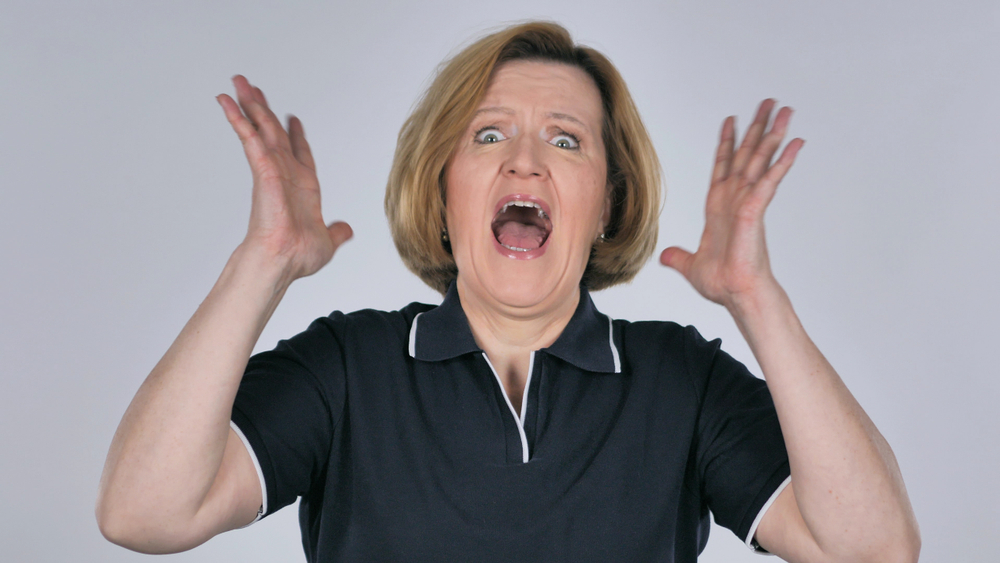

In [488]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(r"/content/5c7c72b655f51.png")
cv2_imshow(img)

In [489]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=np.asarray(img))
#image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

In [490]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

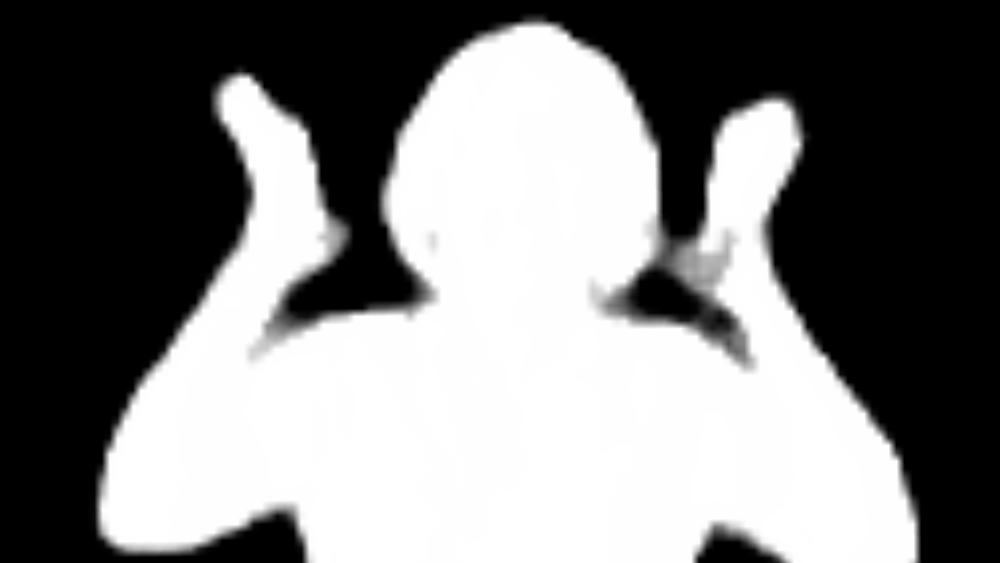

In [491]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)

In [492]:


gray_image = cv2.cvtColor(visualized_mask, cv2.COLOR_BGR2GRAY)

In [493]:
gray_image.dtype

dtype('float32')

In [494]:
gray_image *= 255 # or any coefficient
gray_image = gray_image.astype(np.uint8)

In [495]:



gray_image.dtype

dtype('uint8')

In [496]:

non_white_mask = cv2.bitwise_not(gray_image)

In [497]:

inverted_image = cv2.bitwise_not(non_white_mask)

In [498]:
contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [499]:

max_area = 0
max_rect = None

# Iterate through the contours to find the largest rectangle
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h
    if area > max_area:
        max_area = area
        max_rect = (x, y, x + w, y + h)


In [500]:

x,y,w,h=max_rect


In [501]:
def calculate_vacant_area(image, person_bbox,max_w):
    # Calculate the center of the bounding box
    x, y, width, height = person_bbox
    center_x=width // 2
    center_y =  height // 2

    # Calculate distances from the center to the left and right edges
    distance_to_left_edge = x
    distance_to_right_edge = image.shape[1] - width
    print(distance_to_left_edge)
    print(distance_to_right_edge)
    print(x)

    # Compare the distances to determine which side has more vacant area
    if distance_to_left_edge > max_w  :

      if distance_to_left_edge >= distance_to_right_edge:
        print("check")
        return "Left"
    if distance_to_right_edge > max_w:
      if distance_to_right_edge > distance_to_left_edge:
          return "Right"
    else:
        return "Equal"

In [502]:
print(max_text_box_width)

722


In [503]:


img_width,img_height,_=img.shape
max_text_box_width = img_width-x-100

In [504]:
vacant_area_side = calculate_vacant_area(img, max_rect,max_text_box_width)

87
71
87


In [505]:
print(vacant_area_side)

Equal


block 3


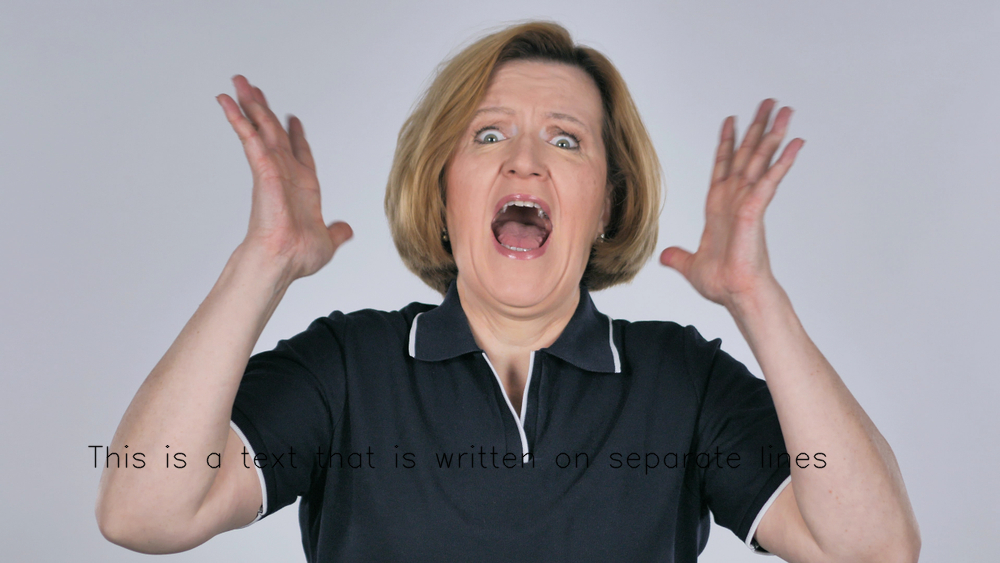

In [514]:




if(vacant_area_side=="Right"):

  text = "This is a text that is written on separate lines"
  print("block 1")
  # Create a bounding box around the text
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_thickness = 1
  text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
  text_width, text_height = text_size
  text_box_width = text_width + 10  # Add some margin
  text_box_height = text_height + 10  # Add some margin

  text_x = int(w)  # Start to the right of the existing bounding box

  text_y = int((h-y)//2)
  ini_y=text_y

  lines = []
  line = ""
  for word in text.split():
    test_line = line + ("" if line == "" else " ") + word
    test_size = cv2.getTextSize(test_line, font, font_scale, font_thickness)[0]
    if test_size[0] <= max_text_box_width:
        line = test_line
    else:
        lines.append(line)
        line = word
  lines.append(line)  # Add the last line

  image_1 = img.copy()


  for line in lines:
    cv2.putText(image_1, line, (text_x, text_y), font, font_scale, 0, font_thickness, cv2.LINE_AA)

    text_y += test_size[1]  # Move to the next line
  cv2_imshow(image_1)

elif(vacant_area_side=="Left"):
  text = "This is a text that is written on separate lines"
  print("block 2")
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_thickness = 1
  text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
  text_width, text_height = text_size
  text_box_width = text_width + 10  # Add some margin
  text_box_height = text_height + 10  # Add some margin
  img_width,img_height,_=img.shape
  max_text_box_width = x-50
  # Calculate the initial text position on the left of the bounding box
  text_x = 0# Start to the left of the existing bounding box

  text_y = int((h - y) // 2)
  ini_y = text_y

  lines = []
  line = ""
  for word in text.split():
      test_line = line + ("" if line == "" else " ") + word
      test_size = cv2.getTextSize(test_line, font, font_scale, font_thickness)[0]
      if test_size[0] <= max_text_box_width:
          line = test_line
      else:
          lines.append(line)
          line = word
  lines.append(line)  # Add the last line

  image_1 = img.copy()

  for line in lines:
      cv2.putText(image_1, line, (text_x, text_y), font, font_scale, 0, font_thickness, cv2.LINE_AA)

      text_y += test_size[1]  # Move to the next line
  cv2_imshow(image_1)

elif(vacant_area_side=="Equal"):
  print("block 3")

  # Initialize MTCNN for face detection
  mtcnn = MTCNN(keep_all=True)

  # Load pre-trained FaceNet model
  resnet = InceptionResnetV1(pretrained='casia-webface').eval()

  # Load an image containing faces

  # Detect faces in the image
  boxes, _ = mtcnn.detect(img)
  fx,fy,fw,fh=boxes[0]
  text = "This is a text that is written on separate lines"

  # Create a bounding box around the text
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 1
  font_thickness = 1
  text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
  text_width, text_height = text_size
  text_box_width = text_width + 10  # Add some margin
  text_box_height = text_height + 10  # Add some margin
  img_width,img_height,_=img.shape

  max_text_box_width = w
  text_x = int(x)  # Start to the right of the existing bounding box

  text_y = int(img_height-fy)//2
  ini_y=text_y
  lines = []
  line = ""
  for word in text.split():
      test_line = line + ("" if line == "" else " ") + word
      test_size = cv2.getTextSize(test_line, font, font_scale, font_thickness)[0]
      if test_size[0] <= max_text_box_width:
          line = test_line
      else:
          lines.append(line)
          line = word
  lines.append(line)  # Add the last line
  image_1 = img.copy()


  for line in lines:
      cv2.putText(image_1, line, (text_x, text_y), font, font_scale, 0, font_thickness, cv2.LINE_AA)

      text_y += test_size[1]  # Move to the next line

  cv2_imshow(image_1)